# Decision Trees and Random Forests

This notebook takes a look at classifying acoustic sounds of the MNIST dataset which can be found at https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist. this dataset consists of sounds for numbers from 0 to 9 from 60 different people with varying nationalities. We will explore a few things:

1) An example sound from one of the numbers
2) Fast Fourier Transform demonstrations and Mel-Frequency Cepstral Coefficients of different numbers and examples
3) Pulling and preprocessing data with feature extraction
4) Hyperparameter optimization through bayesian optimization
5) Training decision and random forest tree classifier from extracted features
6) Model evaluations

By: Ryan McCarthy


In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import librosa 
import librosa.display
import IPython.display as ipd

from glob import glob
import opendatasets as od 

Load and save the audio mnist dataset locally to use for this notebook

In [2]:
od.download('https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist/data')

Skipping, found downloaded files in ".\audio-mnist" (use force=True to force download)


In [3]:
def get_audio(sample=1,digit=0,index=0):
    # Modified file location
    file = f"audio-mnist/data/{sample :02d}/{digit}_{sample :02d}_{index}.wav"
    
    # Get Audio from the location
    data,sr = librosa.load(file)

    # return data and sample rate
    return data,sr

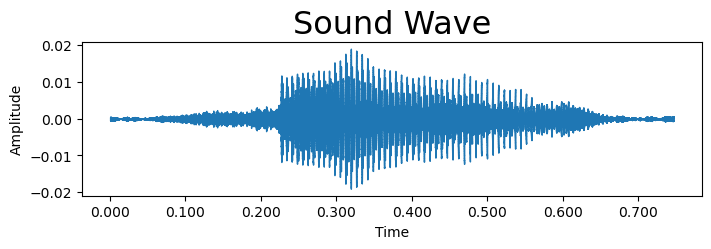

In [4]:
# sample example
sample = 1
digit = 5
index = 1
file = f"audio-mnist/data/{sample :02d}/{digit}_{sample :02d}_{index}.wav"

# Get Audio from the location
y,sr = get_audio(sample=1,digit=0,index=0)

plt.figure(figsize = (8, 2))
librosa.display.waveshow(y = y, sr = sr);
plt.title("Sound Wave", fontsize = 23);
plt.ylabel('Amplitude')
plt.show()

In [5]:
# Play audio file
ipd.Audio(data=y,rate = sr)

## FFT and MFCC Spectrograms
Here we demonstrate both the FFT and MFCC spectra which will be used to extract features for the models to learn from

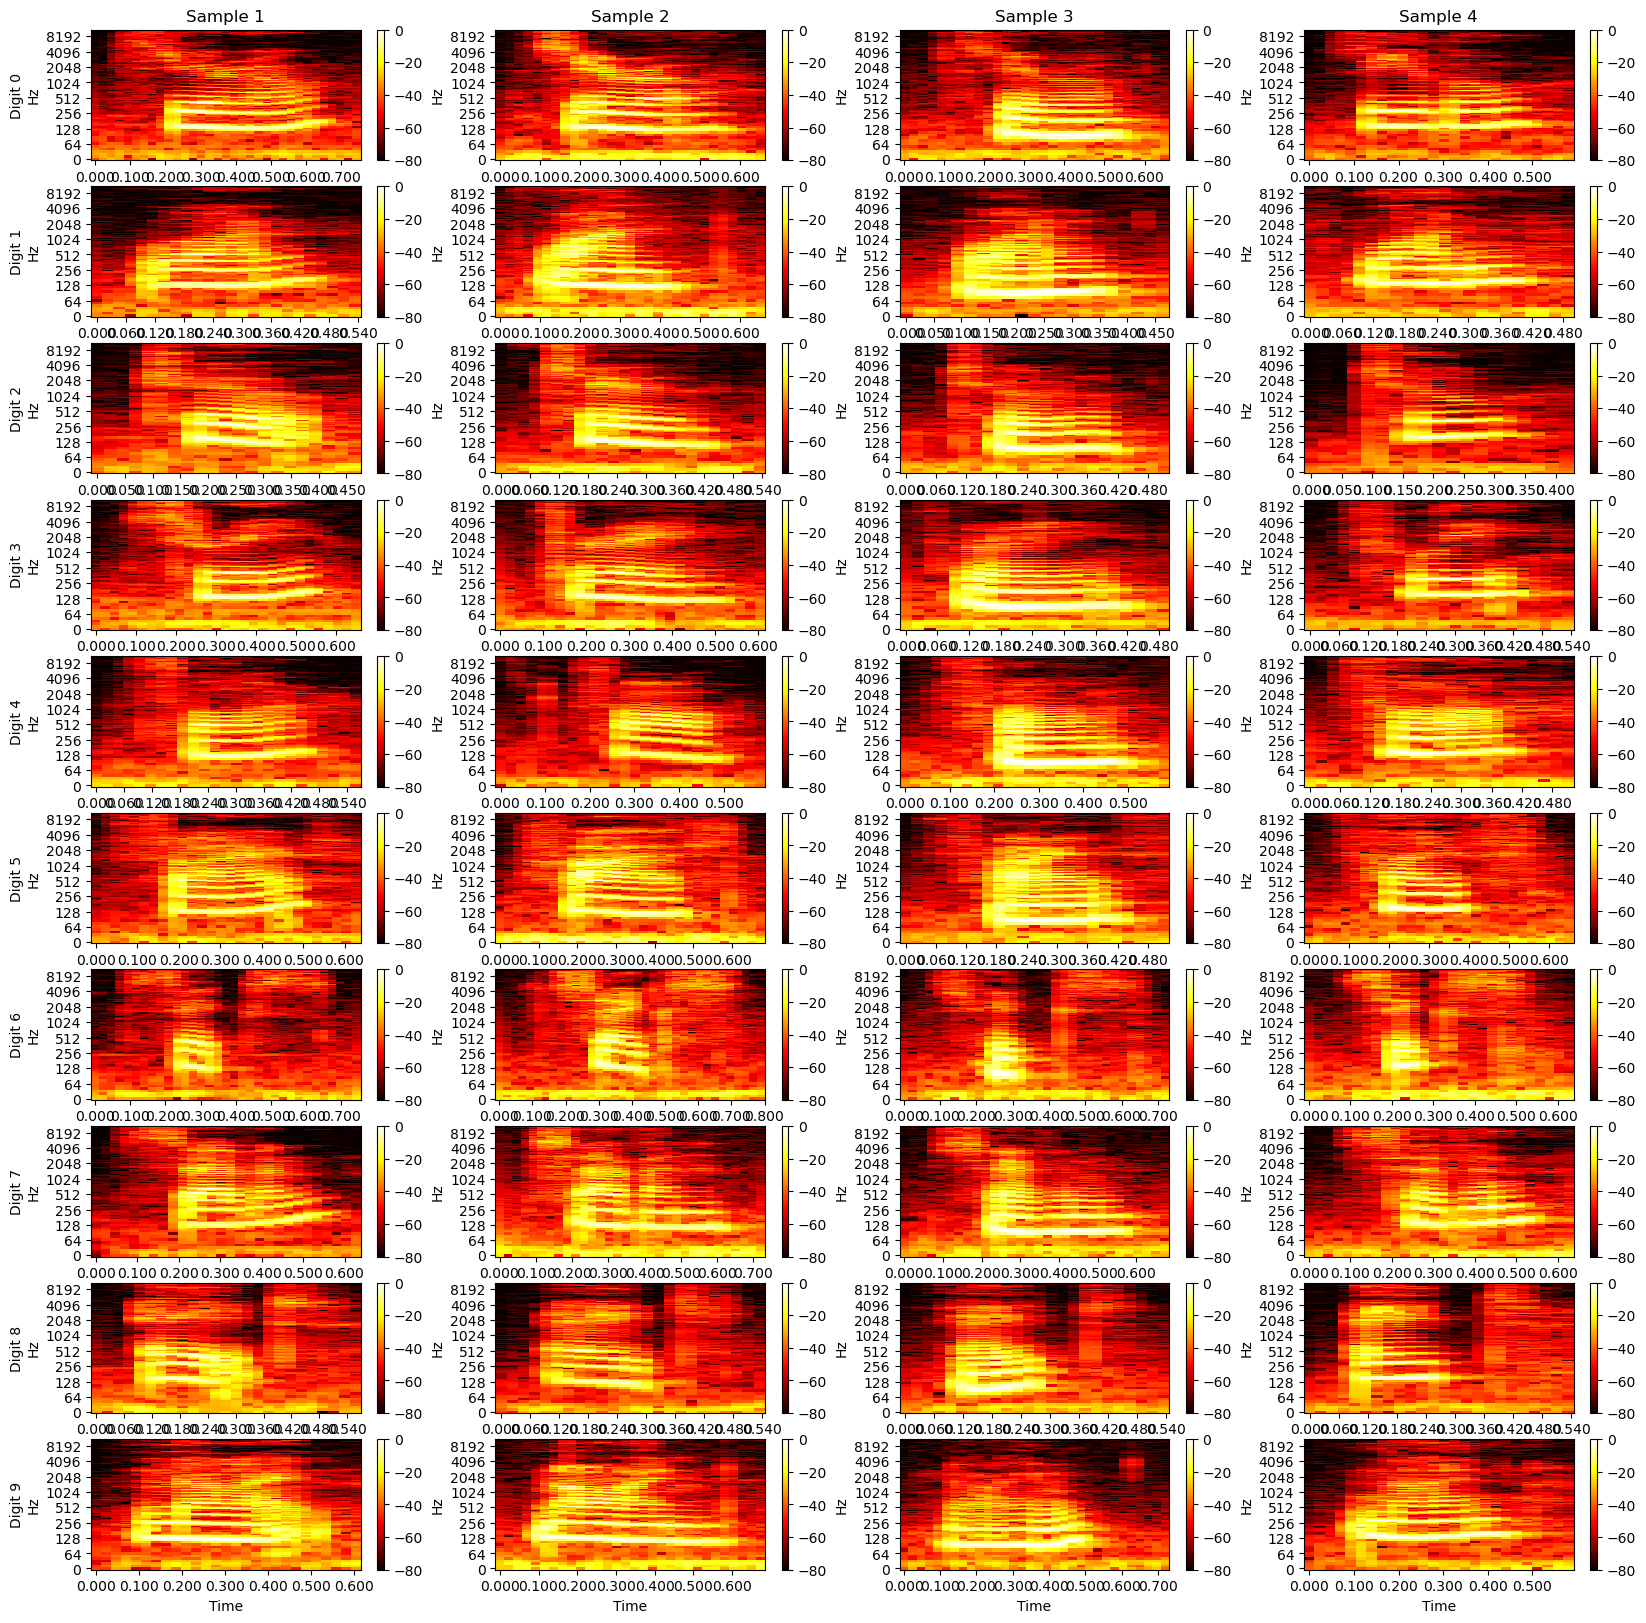

In [6]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Creating the Spectogram
plt.figure(figsize = (20, 20))
ind = 1

for dig_num in range(0,10):
    for sam_num in range(1,5):
        # Go through different examples
        y,sr = get_audio(sample=sam_num,digit=dig_num,index=0)
        
        # Short-time Fourier transform (STFT)
        D = np.abs(librosa.stft(y, n_fft = n_fft, hop_length = hop_length))
        
        # Convert an amplitude spectrogram to Decibels-scaled spectrogram.
        DB = librosa.amplitude_to_db(D, ref = np.max)
        
        plt.subplot(10,4,ind)
        librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                                cmap = 'hot')
        plt.colorbar();
        if (ind-1)%4 == 0 or ind==1:
            plt.ylabel(f"Digit {dig_num}\nHz") 

        if dig_num == 0:
            plt.title(f"Sample {sam_num}")
            
        ind +=1

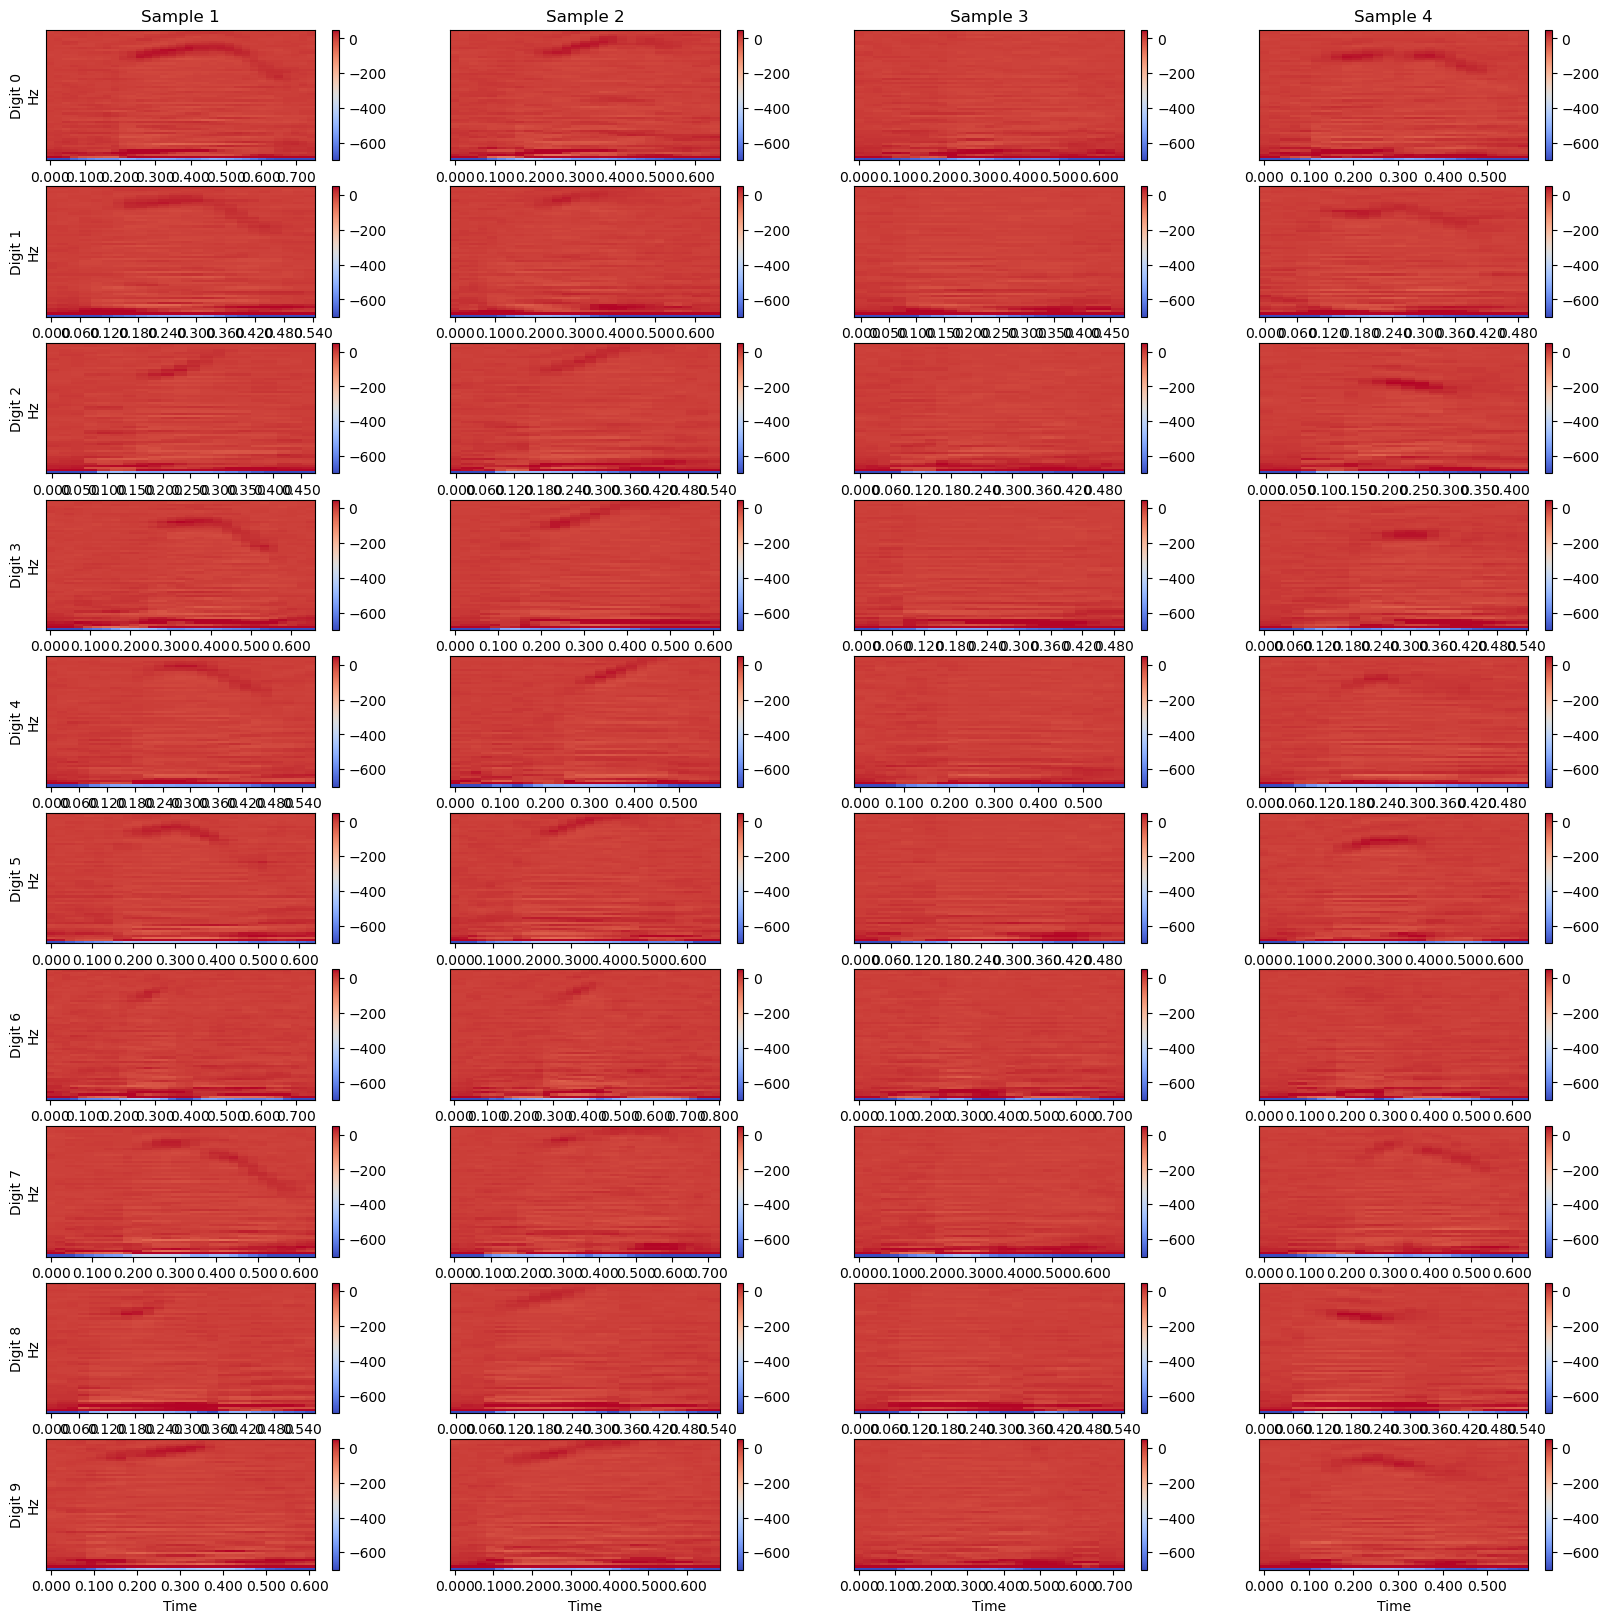

In [12]:
# Creating the Spectogram
plt.figure(figsize = (20, 20))
ind = 1

for dig_num in range(0,10):
    for sam_num in range(1,5):
        # Go through different examples
        y,sr = get_audio(sample=sam_num,digit=dig_num,index=0)
        
        # Short-time Fourier transform (STFT)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=60)
        
        # Convert an amplitude spectrogram to Decibels-scaled spectrogram.
        #DB = librosa.amplitude_to_db(D, ref = np.max)
        
        plt.subplot(10,4,ind)
        librosa.display.specshow(mfccs, sr = sr, x_axis = 'time')
        plt.clim(vmin=-700,vmax=50)
        plt.colorbar();
        if (ind-1)%4 == 0 or ind==1:
            plt.ylabel(f"Digit {dig_num}\nHz") 

        if dig_num == 0:
            plt.title(f"Sample {sam_num}")
            
        ind +=1

# Feature Extraction
Here we will define functions to extract features for both the FFT and MFCC specta. We will take the mean and standard deviation across each frequency component to use to train and test our models.

In [52]:
# will take a audio file as input and output extracted features using MEL_FREQUENCY CEPSTRAL COEFFICIENT
def extract_features_fft(file):
    # Default FFT window size
    n_fft = 1024 # FFT window size
    hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

    # Load audio and sample rate of audio
    audio,sample_rate = librosa.load(file)
    # Short-time Fourier transform (STFT)
    D = np.abs(librosa.stft(audio, n_fft = n_fft, hop_length = hop_length))
    
    # Convert an amplitude spectrogram to Decibels-scaled spectrogram.
    DB = librosa.amplitude_to_db(D, ref = np.max)
    
    # Scale the extracted features
    extracted_features = np.concatenate((np.mean(DB.T,axis=0),np.std(DB.T,axis=0)))
    # Return the extracted features
    return extracted_features

def preprocess_and_create_dataset_fft():
    # Path of folder where the audio files are present
    root_folder_path = "audio-mnist/data/"
    # Empth List to create dataset
    dataset = []
    
    # Iterating through folders where each folder has audio of each digit
    for folder in tqdm(range(1,61)):
        folder = os.path.join(root_folder_path,f'{folder:02d}')
        
        # Iterate through each file of the present folder
        for file in os.listdir(folder):
            # Path of the file
            file_path = os.path.join(folder,file)
            # Pass path of file to extracted_features() function to create features
            extracted_features = extract_features_fft(file_path) 
            # Class of the audio,i.e., the digit it represents
            class_label = int(file[0])

            # Append a list where the feature represents a column and class of the digit represents another column
            dataset.append([extracted_features,class_label])
    
    return pd.DataFrame(dataset,columns=['features','class'])

def extract_features_mfcc(file):
    # Load audio and sample rate of audio
    audio,sample_rate = librosa.load(file)
    # Extract features using mel-frequency coefficient
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60)
    
    # Scale the extracted features
    extracted_features = np.concatenate((np.mean(mfccs.T,axis=0),np.std(mfccs.T,axis=0)))
    # Return the extracted features
    return extracted_features

def preprocess_and_create_dataset_mfcc():
    # Path of folder where the audio files are present
    root_folder_path = "audio-mnist/data/"
    # Empth List to create dataset
    dataset = []
    
    # Iterating through folders where each folder has audio of each digit
    for folder in tqdm(range(1,61)):
        folder = os.path.join(root_folder_path,f'{folder:02d}')
        
        # Iterate through each file of the present folder
        for file in os.listdir(folder):
            # Path of the file
            file_path = os.path.join(folder,file)
            # Pass path of file to extracted_features() function to create features
            extracted_features = extract_features_mfcc(file_path) 
            # Class of the audio,i.e., the digit it represents
            class_label = int(file[0])

            # Append a list where the feature represents a column and class of the digit represents another column
            dataset.append([extracted_features,class_label])
    
    return pd.DataFrame(dataset,columns=['features','class'])

In [53]:
# process all the data and extract features/labels
Data_fft = preprocess_and_create_dataset_fft()
Data_mfcc = preprocess_and_create_dataset_mfcc()

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [02:10<00:00,  2.18s/it]


Here we will split our data into training and testing data as well as standardize our data

In [47]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import optuna

# this is to stop the bayesian optimization from printing 
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [54]:
# fft features and scaled
X_fft = np.vstack(Data_fft['features'].values)
y_fft = np.array(Data_fft['class'].values)
X_train_fft, X_test_fft, y_train_fft, y_test_fft = train_test_split(X_fft, y_fft, test_size=0.20, shuffle=True, random_state=42)
scaler_fft = StandardScaler()
X_train_fft = scaler_fft.fit_transform(X_train_fft)
X_test_fft = scaler_fft.transform(X_test_fft)

# mfcc features and scaled
X_mfcc = np.vstack(Data_mfcc['features'].values)
y_mfcc = np.array(Data_mfcc['class'].values)
X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc = train_test_split(X_mfcc, y_mfcc, test_size=0.20, shuffle=True, random_state=42)
scaler_mfcc = StandardScaler()
X_train_mfcc = scaler_mfcc.fit_transform(X_train_mfcc)
X_test_mfcc = scaler_mfcc.transform(X_test_mfcc)

In [49]:
# Define an objective function to be maximized for decision tree
def objective_decisiontree(trial,X_train, y_train):
    dt_max_depth = trial.suggest_int('max_depth', 4, 100, log=True)
    dt_crit = trial.suggest_categorical('criterion',["gini", "entropy", "log_loss"])
    dt_split = trial.suggest_categorical('splitter',["best", "random"])
    classifier_obj = DecisionTreeClassifier(criterion=dt_crit,splitter=dt_split,max_depth=dt_max_depth)
    accuracy = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1, cv=3).mean()
    
    return accuracy

# Define an objective function to be maximized for random forest
def objective_randomforest(trial,X_train, y_train):
    rf_num_est = trial.suggest_int('n_estimators', 2, 50, log=True)
    rf_max_depth = trial.suggest_int('max_depth', 4, 100, log=True)
    rf_crit = trial.suggest_categorical('criterion',["gini", "entropy", "log_loss"])
    classifier_obj = RandomForestClassifier(n_estimators=rf_num_est,criterion=rf_crit,max_depth=rf_max_depth)
    accuracy = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1, cv=3).mean()
    
    return accuracy

We will now identify the best hyperparameters to use for the DT models

In [55]:
# Decision tree study object and optimize the objective function on the fft data.
study_dt_fft = optuna.create_study(direction='maximize')
study_dt_fft.optimize(lambda trial: objective_decisiontree(trial, X_train_fft, y_train_fft), n_trials=20)
print("Completed Optimization fft DT")

Completed Optimization fft DT


In [56]:
# Decision tree study object and optimize the objective function on the mfcc data.
study_dt_mfcc = optuna.create_study(direction='maximize')
study_dt_mfcc.optimize(lambda trial: objective_decisiontree(trial, X_train_mfcc, y_train_mfcc), n_trials=20)
print("Completed Optimization mfcc DT")

Completed Optimization mfcc DT


In [57]:
model_dt_fft = DecisionTreeClassifier(max_depth=study_dt_fft.best_params['max_depth'],criterion=study_dt_fft.best_params['criterion'],splitter=study_dt_fft.best_params['splitter'])
model_dt_fft.fit(X_train_fft,y_train_fft)
print('DT fft model fit')

model_dt_mfcc = DecisionTreeClassifier(max_depth=study_dt_mfcc.best_params['max_depth'],criterion=study_dt_mfcc.best_params['criterion'],splitter=study_dt_mfcc.best_params['splitter'])
model_dt_mfcc.fit(X_train_mfcc,y_train_mfcc)
print('DT mfcc model fit')

DT fft model fit
DT mfcc model fit


We will now identify the best hyperparameters to use for the RF models

In [58]:
# Random forest study object and optimize the objective function on the mfcc data.
study_rf_fft = optuna.create_study(direction='maximize')
study_rf_fft.optimize(lambda trial: objective_randomforest(trial, X_train_fft, y_train_fft), n_trials=20)
print("Completed Optimization fft RF")

Completed Optimization fft RF


In [59]:
# Create a study object and optimize the objective function on the mfcc data.
study_rf_mfcc = optuna.create_study(direction='maximize')
study_rf_mfcc.optimize(lambda trial: objective_randomforest(trial, X_train_mfcc, y_train_mfcc), n_trials=20)
print("Completed Optimization mfcc RF")

Completed Optimization mfcc RF


In [60]:
model_rf_fft = RandomForestClassifier(n_estimators=study_rf_fft.best_params['n_estimators'],criterion=study_rf_fft.best_params['criterion'],max_depth=study_rf_fft.best_params['max_depth'])
model_rf_fft.fit(X_train_fft,y_train_fft)
print('RF fft model fit')

model_rf_mfcc = RandomForestClassifier(n_estimators=study_rf_mfcc.best_params['n_estimators'],criterion=study_rf_mfcc.best_params['criterion'],max_depth=study_rf_mfcc.best_params['max_depth'])
model_rf_mfcc.fit(X_train_mfcc,y_train_mfcc)
print('RF mfcc model fit')

RF fft model fit
RF mfcc model fit


# Model Comparison Accuracy Scores

In [61]:
# decision tree preditictions
ytrain_pred_dt = model_dt_fft.predict(X_train_fft)
ytest_pred_dt = model_dt_fft.predict(X_test_fft)

acctrain_dt = accuracy_score(y_train_fft,ytrain_pred_dt)
acctest_dt = accuracy_score(y_test_fft,ytest_pred_dt)

# Random Forest Predicitons
ytrain_pred_rf = model_rf_fft.predict(X_train_fft)
ytest_pred_rf = model_rf_fft.predict(X_test_fft)

acctrain_rf = accuracy_score(y_train_fft,ytrain_pred_rf)
acctest_rf = accuracy_score(y_test_fft,ytest_pred_rf)

# Print out
print(f"Accuracies fft features")
print("------------------------")
print(f"Training Accuracy Decision Tree: {acctrain_dt}")
print(f"Testing Accuracy Decision Tree: {acctest_dt}")
print("")
print(f"Training Accuracy Random Forest: {acctrain_rf}")
print(f"Testing Accuracy Random Forest: {acctest_rf}")

Accuracies fft features
------------------------
Training Accuracy Decision Tree: 1.0
Testing Accuracy Decision Tree: 0.755

Training Accuracy Random Forest: 1.0
Testing Accuracy Random Forest: 0.9273333333333333


In [62]:
# decision tree preditictions
ytrain_pred_dt = model_dt_mfcc.predict(X_train_mfcc)
ytest_pred_dt = model_dt_mfcc.predict(X_test_mfcc)

acctrain_dt = accuracy_score(y_train_mfcc,ytrain_pred_dt)
acctest_dt = accuracy_score(y_test_mfcc,ytest_pred_dt)

# Random Forest Predicitons
ytrain_pred_rf = model_rf_mfcc.predict(X_train_mfcc)
ytest_pred_rf = model_rf_mfcc.predict(X_test_mfcc)

acctrain_rf = accuracy_score(y_train_mfcc,ytrain_pred_rf)
acctest_rf = accuracy_score(y_test_mfcc,ytest_pred_rf)

# Print out
print(f"Accuracies mfcc features")
print("------------------------")
print(f"Training Accuracy Decision Tree: {acctrain_dt}")
print(f"Testing Accuracy Decision Tree: {acctest_dt}")
print("")
print(f"Training Accuracy Random Forest: {acctrain_rf}")
print(f"Testing Accuracy Random Forest: {acctest_rf}")

Accuracies mfcc features
------------------------
Training Accuracy Decision Tree: 1.0
Testing Accuracy Decision Tree: 0.8705

Training Accuracy Random Forest: 1.0
Testing Accuracy Random Forest: 0.9863333333333333


We can see from the two models, the RF model performs the best. Additionally, we can see that the MFCC extracted features provide better features for model predictions.

# Confusion Matrices 
Confusion matrices allow us to see where the model fails for each predicted label. Diagonals represent correct classifications while off diagonals show what examples the model incorrectly predicts. In the confusion matrix, we shall only look at the random forest classifier and compare the difference between the models trained with FFT and MFCC features.

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay

RF FFT feature model predictions

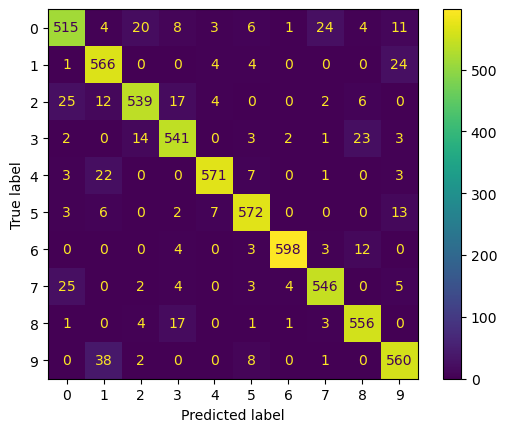

In [73]:
ConfusionMatrixDisplay.from_estimator(model_rf_fft,X_test_fft,y_test_fft)

RF MFCC feature model predictions

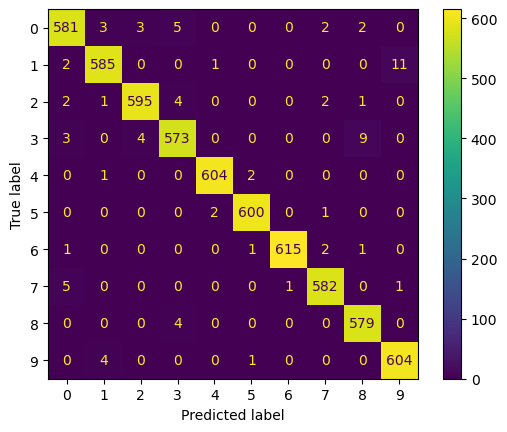

In [74]:
ConfusionMatrixDisplay.from_estimator(model_rf_mfcc,X_test_mfcc,y_test_mfcc)

# Classification Report for Testing Data 

In [77]:
from sklearn.metrics import classification_report

In [79]:
print("Report for FFT features RF")
print("--------------------------")
print(classification_report(y_test_fft, model_rf_fft.predict(X_test_fft)))
print("")
print("Report for MFCC features RF")
print("--------------------------")
print(classification_report(y_test_mfcc, model_rf_mfcc.predict(X_test_mfcc)))

Report for FFT features RF
--------------------------
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       596
           1       0.87      0.94      0.91       599
           2       0.93      0.89      0.91       605
           3       0.91      0.92      0.92       589
           4       0.97      0.94      0.95       607
           5       0.94      0.95      0.95       603
           6       0.99      0.96      0.98       620
           7       0.94      0.93      0.93       589
           8       0.93      0.95      0.94       583
           9       0.90      0.92      0.91       609

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000


Report for MFCC features RF
--------------------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       596
           1       0.9

Above we report the precision, recall, and f1-scores for both of the RF models. Overall we can see that the model trained with MFCC features has higher values overall and thus is a better model to use to distinguish between the different sounds.

# Varying Training and Testing Sizes 
Here we will look at how the sizes of training and testing data will impact the overall results of the models. We use the optimized parameters identified previously.

In [66]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import LearningCurveDisplay

FFT features

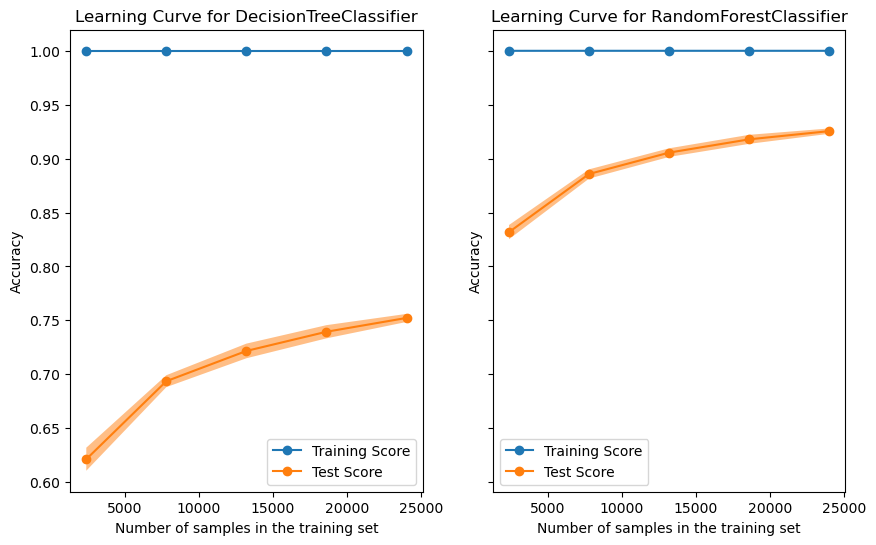

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

decision_tree_fft_vary = DecisionTreeClassifier(max_depth=study_dt_fft.best_params['max_depth'],criterion=study_dt_fft.best_params['criterion'],splitter=study_dt_fft.best_params['splitter'])
random_forest_fft_vary = RandomForestClassifier(n_estimators=study_rf_fft.best_params['n_estimators'],criterion=study_rf_fft.best_params['criterion'],max_depth=study_rf_fft.best_params['max_depth'])

common_params_fft = {
    "X": X_fft,
    "y": y_fft,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=20, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([decision_tree_fft_vary, random_forest_fft_vary]):
    LearningCurveDisplay.from_estimator(estimator, **common_params_fft, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

MFCC features 

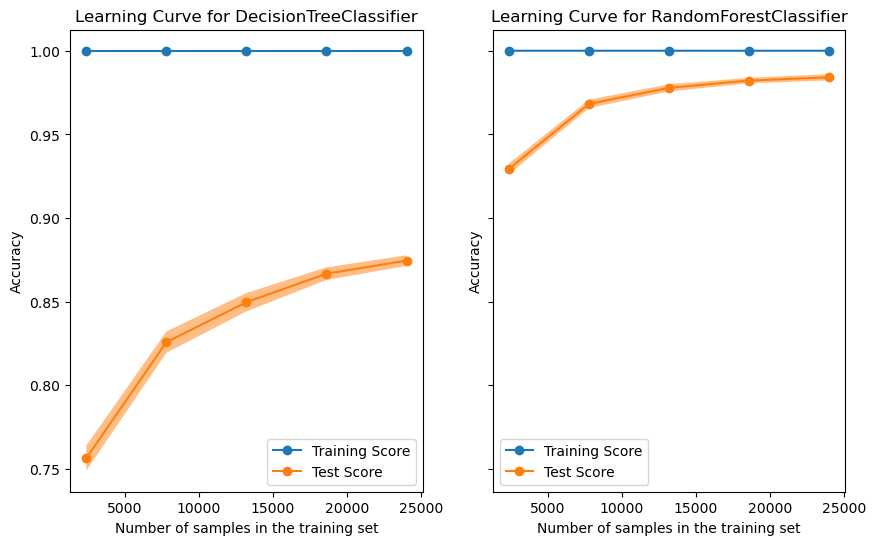

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

decision_tree_mfcc_vary = DecisionTreeClassifier(max_depth=study_dt_mfcc.best_params['max_depth'],criterion=study_dt_mfcc.best_params['criterion'],splitter=study_dt_mfcc.best_params['splitter'])
random_forest_mfcc_vary = RandomForestClassifier(n_estimators=study_rf_mfcc.best_params['n_estimators'],criterion=study_rf_mfcc.best_params['criterion'],max_depth=study_rf_mfcc.best_params['max_depth'])

common_params_mfcc = {
    "X": X_mfcc,
    "y": y_mfcc,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=20, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([decision_tree_mfcc_vary, random_forest_mfcc_vary]):
    LearningCurveDisplay.from_estimator(estimator, **common_params_mfcc, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

Takeaways from the above curves are that there is a 10% difference in overall accuracy for the DT models when having a smaller sample size vs a larger. Similarly, there is about a 10-20% difference in accuracy scores between the DT and RF models for each sample size. In the fft and mfcc RF models, we can see that there after 15000 training data, there is marginal accuracy score improvements. 

# Citations

1) S. Becker, J. Vielhaben, M. Ackermann, K.-R. Müller, S. Lapuschkin, and W. Samek, ‘AudioMNIST: Exploring Explainable Artificial Intelligence for audio analysis on a simple benchmark’, Journal of the Franklin Institute, vol. 361, no. 1, pp. 418–428, 2024.